This notebook generates the network diagram using networkX using the network diagram

In [62]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

### Import Network Diagram

In [23]:
directory = '../data/'

In [3]:
network_df = pd.read_csv(directory+'Tweet_table.csv')
network_df.columns = ['user1', 'user2', 'type']

In [126]:
network_df

,user1,user2,type
0,@Blue_Footy,@Blue_Footy,Tweet
1,@QuesiTee,@Blue_Footy,Retweet
2,@JamesOlley,@JamesOlley,Tweet
3,@tommyboyjazzman,@JamesOlley,Retweet
4,@premierleague,@premierleague,Tweet
...,...,...,...
8353,@ErikSarni1,@LAConqsGBBall,Retweet
8354,@ArsenalWFC,@ArsenalWFC,Tweet
8355,@Lammoye,@ArsenalWFC,Retweet
8356,@ManUtd,@ManUtd,Tweet


### Graph Functions

In [16]:
# Colorful graph plot function

def nx_plot(G):
    pos = nx.spring_layout(G)

    node_sizes = [3 + 10 * i for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    cmap = plt.cm.plasma

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=2,
    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])

    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)
    plt.colorbar(pc)

    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

In [196]:
# Generate degree distribution plots function

def degree_dist(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

### Generate Graph

In [117]:
def gen_graph(network_df):
    rt_in = network_df.type=='Retweet'
    rts = network_df[rt_in]
    tweets = network_df.drop(index= rts.index)
    graph = nx.DiGraph()
    graph.add_edges_from(zip(rts.user1, rts.user2), ttype = 'RT')
    graph.add_edges_from(zip(tweets.user1, tweets.user2), ttype = 'tweet')
    return graph

In [118]:
graph = gen_graph(network_df)

### Draw Simple Graph

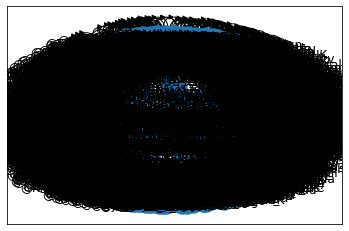

In [119]:
nx.draw_networkx(graph)

### Network Features

In [66]:
degree = pd.DataFrame(pd.Series(dict(graph.degree)), columns=['degree'])

In [19]:
centrality = pd.Series(nx.algorithms.centrality.betweenness.betweenness_centrality(graph)).sort_values()

In [20]:
closeness =pd.Series(nx.algorithms.centrality.closeness.closeness_centrality(graph)).sort_values(ascending=False)

In [77]:
retweets_res = network_df[network_df.type == "Retweet"].groupby('user2').aggregate({'type':'count'})
retweets_res.columns = ['retweet']

### User Features

In [182]:
user_df = pd.read_csv(directory+'users_info_df.csv')
user_df.drop_duplicates(inplace=True, subset='screen_name')
user_df.set_index('@'+user_df.screen_name , drop = True, inplace = True) 
user_df = user_df.iloc[:, 3:]
user_df = user_df.join([degree, retweets_res])
user_df.fillna(0, inplace = True)

In [183]:
user_df

,followers_count,friends_count,listed_count,statuses_count,degree,retweet
screen_name,,,,,,
@QuesiTee,278.0,1117.0,1.0,26017.0,1.0,0.0
@tommyboyjazzman,217.0,1263.0,5.0,1102.0,2.0,0.0
@ellah_maih,212.0,236.0,0.0,8423.0,1.0,0.0
@OkerekeChidieb2,500.0,480.0,1.0,5988.0,1.0,0.0
@stratisplatform,161079.0,193.0,1806.0,2458.0,1.0,0.0
...,...,...,...,...,...,...
@ThePaulMachin,59733.0,1521.0,259.0,19178.0,3.0,1.0
@ValencyWiry,68.0,95.0,0.0,143.0,3.0,1.0
@AyewAndre,598521.0,74.0,656.0,1464.0,3.0,1.0


### Influencer Scores

In [184]:
scaler = StandardScaler()
user_df = pd.DataFrame(scaler.fit_transform(user_df), columns=user_df.columns, index = user_df.index)

In [185]:
weights = pd.read_csv(directory+'Weights_v2.csv', index_col=0).T

In [186]:
weights

Feature,Listed,Followers,Retweets,Feature 1,Posts
Weight,0.299,0.244,0.202,0.143,0.112


In [187]:
user_df['score'] = weights.Listed[0]*user_df.listed_count\
                    +weights.Followers[0]*user_df.followers_count\
                    +weights.Retweets[0]*user_df.retweet\
                    +weights['Feature 1'][0]*user_df.degree\
                    +weights.Posts[0]*user_df.statuses_count

### Top 100 Influencers

In [214]:
top100 = list(user_df.nlargest(100, columns=['score']).index)
top100scores =  list(user_df.score.nlargest(100))

In [215]:
net_tab = network_df[network_df.user1.isin(top100)]

In [216]:
net_tab

,user1,user2,type
4,@premierleague,@premierleague,Tweet
6,@CesarAzpi,@CesarAzpi,Tweet
10,@goal,@goal,Tweet
12,@TrollFootball,@TrollFootball,Tweet
14,@BarcaWorldwide,@BarcaWorldwide,Tweet
...,...,...,...
8344,@ChelseaFC,@ChelseaFC,Tweet
8346,@UtdDistrict,@UtdDistrict,Tweet
8348,@ESPNFC,@ESPNFC,Tweet
8350,@ChampionsLeague,@ChampionsLeague,Tweet


In [217]:
graph = gen_graph(net_tab)

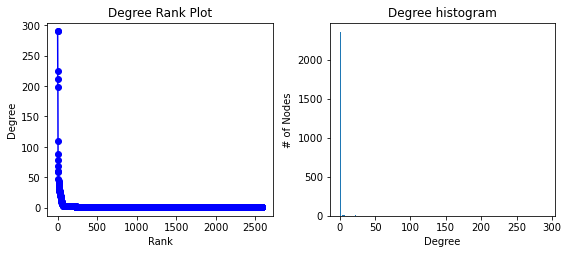

In [218]:
degree_dist(G)

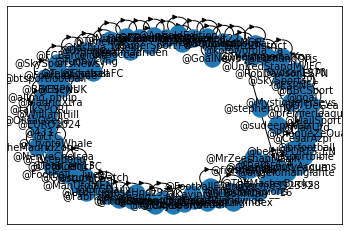

In [224]:
nx.draw_networkx(graph, font_size = 10)

In [219]:
len(graph.nodes)

99